<a href="https://colab.research.google.com/github/Ar11-kgp/Quantitative-Analysis-of-Financial-Trends-in-NSE-Orderbook-Data/blob/main/2012_Indecisive_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpoint 1: Initial Data Handling and Chunking


In [ ]:
import pandas as pd
import gzip
import os


In [ ]:
import psutil
mem = psutil.virtual_memory()
print(f'Total memory: {mem.total / (1024**3):.2f} GB')
print(f'Available memory: {mem.available / (1024**3):.2f} GB')

Total memory: 12.67 GB
Available memory: 11.25 GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CASH_Orders_11092012.DAT.gz'

Mounted at /content/drive


In [ ]:
if os.path.isfile(file_path):
    print("File found!")
else:
    print("File not found!")

File found!


### Defining a path in my Google Drive to save the chunks

In [ ]:
save_path = '/content/drive/My Drive/processed_chunks'
os.makedirs(save_path, exist_ok=True)

### Counting the total number of orders (rows)

In [ ]:
row_count = 0

with gzip.open(file_path, 'rt') as f:
    for _ in f:
        row_count += 1

print(f'Total number of rows: {row_count}')

### Reading the large dataset in chunks and saving each chunk as a separate CSV file to avoid memory overload

In [ ]:
chunksize = 10**7  # 10 million rows per chunk

# Initializing a counter to keep track of the total number of processed rows
total_rows_processed = 0

# Using a list to collect results from each chunk if necessary
results = []

with gzip.open(file_path, 'rt') as f:
    for chunk in pd.read_csv(file_path, delimiter=',', chunksize=chunksize, header=None):

        print(f'Processing chunk with shape: {chunk.shape}')

        # Converting each chunk to DataFrame
        df_chunk = pd.DataFrame(chunk)

        chunk_stats = df_chunk.describe()
        results.append(chunk_stats)

        # Updating the total number of processed rows
        total_rows_processed += chunk.shape[0]

        print(f'Total rows processed so far: {total_rows_processed}')

        # Clearing memory used by the chunk
        del df_chunk
        del chunk
        import gc
        gc.collect()

print(f'Total rows processed: {total_rows_processed}')

# Combining all the results and displaying
combined_results = pd.concat(results)
print(combined_results)

Processing chunk with shape: (10000000, 1)
Total rows processed so far: 10000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 20000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 30000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 40000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 50000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 60000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 70000000
Processing chunk with shape: (10000000, 1)
Total rows processed so far: 80000000
Processing chunk with shape: (6135112, 1)
Total rows processed so far: 86135112
Total rows processed: 86135112
                                                        0
count                                            10000000
unique                                           10000000
top     POCASH201209110000064367621434189176S1bbAXISBA...
freq     

# Checkpoint 2: Segmenting Rows in Chunks and Cleaning the data

In [ ]:
# Defining the segment sizes and corresponding column names
segment_sizes = [2, 4, 16, 14, 1, 1, 10, 2, 8, 8, 8, 8, 1, 1, 1, 1, 1]
column_names = ["Record Indicator", "Segment", "Order Number", "Transaction Time",
                "Buy/Sell Indicator", "Activity Type", "Symbol", "Series", "Volume Disclosed",
                "Volume Original", "Limit Price", "Trigger Price", "Market Order Flag",
                "Stop Loss Flag", "IO Flag", "Algo Indicator", "Client Identity Flag"]

# This will store DataFrame chunks
df_chunks = []

chunk_size = (10**7)  # Number of lines to read per chunk

chunk_count = 0

with gzip.open(file_path, 'rt') as f:
    chunk = f.readlines(chunk_size)
    while chunk:
        # Processing each line in the chunk
        data = []
        for line in chunk:
            segments = []
            start = 0
            for size in segment_sizes:
                segments.append(line[start:start+size])
                start += size
            data.append(segments)

        # A DataFrame for the current chunk
        df_chunk = pd.DataFrame(data, columns=column_names)

        # Saving the chunk to a CSV file
        chunk_file_name = f'chunk_{chunk_count}.csv'
        df_chunk.to_csv(chunk_file_name, index=False)

        # Clearing memory used by current chunk data
        del data, df_chunk, segments, line
        chunk_count += 1

        # Reading the next chunk
        chunk = f.readlines(chunk_size)

print(f'Processed and saved {chunk_count} chunks.')

Processed and saved 758 chunks.


### To remove the character 'b' from Symbols

In [ ]:
import glob

# Function to remove 'b' from the 'Symbol' column
def clean_symbol(symbol):
    return symbol.lstrip('b')

# Processing each chunk file one by one
for chunk_file in glob.glob('chunk_*.csv'):
    df_chunk = pd.read_csv(chunk_file)
    # Cleaning the 'Symbol' column
    df_chunk['Symbol'] = df_chunk['Symbol'].apply(clean_symbol)
    # Saving the cleaned chunk
    df_chunk.to_csv(chunk_file, index=False)

print("Symbols cleaned and saved to chunks.")


Symbols cleaned and saved to chunks.


### To convert jiffies format values to timestamp

In [ ]:
import datetime

# Function to convert jiffies to timestamp
def jiffies_to_timestamp(jiffies):
    seconds = jiffies / 65536.0
    base_time = datetime.datetime(1980, 1, 1)
    new_time = base_time + datetime.timedelta(seconds=seconds)
    return new_time.strftime('%H.%M.%S.%f')

for chunk_file in glob.glob('chunk_*.csv'):
    df_chunk = pd.read_csv(chunk_file)
    # Converting the 'Transaction Time' column
    df_chunk['Transaction Time'] = df_chunk['Transaction Time'].apply(jiffies_to_timestamp)
    # Saving the updated chunk
    df_chunk.to_csv(chunk_file, index=False)

print("Transaction times converted and saved to chunks.")


Transaction times converted and saved to chunks.


In [ ]:
chunkcsv  = pd.read_csv('/content/drive/MyDrive/processed_chunks/chunk_0.csv')
chunkcsv.head()

,Data
0,POCASH201209110000064367621434189176S1bbAXISBA...
1,POCASH201209110000064467621434192947B1bbAXISBA...
2,POCASH201209110000065167621434193749S1bTATASTE...
3,POCASH201209110000065267621434193758S1bbbbbbBH...
4,POCASH201209110000064567621434193764B1bbbbbCAI...


### Processing all the updated chunks and saving them

In [ ]:
# Path to save processed chunks
save_path = '/content/drive/My Drive/processed_chunks'

# Initialize chunk processing
chunk_size = 10**7  # 10 million rows per chunk
total_rows = 86135112  # Total number of rows in the dataset

# Process the file in chunks
chunk_number = 0
processed_rows = 0

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header=None, compression='gzip'):

    chunk.columns = ['Data']

    # Saving the processed chunk to Google Drive
    chunk_file = os.path.join(save_path, f'chunk_{chunk_number}.csv')
    chunk.to_csv(chunk_file, index=False)
    chunk_number += 1
    processed_rows += len(chunk)
    print(f'Processed rows so far: {processed_rows}')

print("All chunks processed and saved to Google Drive.")


Processed rows so far: 10000000
Processed rows so far: 20000000
Processed rows so far: 30000000
Processed rows so far: 40000000
Processed rows so far: 50000000
Processed rows so far: 60000000
Processed rows so far: 70000000
Processed rows so far: 80000000
Processed rows so far: 86135112
All chunks processed and saved to Google Drive.


### After processing each chunk, I used garbage collection to free up memory.

In [ ]:
os._exit(00)


# Checkpoint 3: Ensuring the segmentation and clean up

In [ ]:
import gc

load_path = '/content/drive/My Drive/processed_chunks'

# Path to save segmented chunks
segmented_path = '/content/drive/My Drive/segmented_chunks'

# To ensure the segmented directory exists
if not os.path.exists(segmented_path):
    os.makedirs(segmented_path)

column_names = [
    "Record Indicator", "Segment", "Order Number", "Transaction Time",
    "Buy/Sell Indicator", "Activity Type", "Symbol", "Series", "Volume Disclosed",
    "Volume Original", "Limit Price", "Trigger Price", "Market Order Flag",
    "Stop Loss Flag", "IO Flag", "Algo Indicator", "Client Identity Flag"
]

segment_lengths = [2, 4, 16, 14, 1, 1, 10, 2, 8, 8, 8, 8, 1, 1, 1, 1, 1]

# Function to segment each row based on defined lengths
def segment_row(row, lengths):
    positions = [sum(lengths[:i]) for i in range(len(lengths) + 1)]
    return [row[positions[i]:positions[i+1]].strip() for i in range(len(lengths))]

In [ ]:
# Function to process each chunk file in smaller batches
def process_chunk_in_batches(file_path, output_path, batch_size=100000):
    chunk_data = pd.read_csv(file_path, header=None)
    total_rows = len(chunk_data)

    batch_number = 0
    for start in range(0, total_rows, batch_size):
        end = min(start + batch_size, total_rows)
        segmented_data = [segment_row(row, segment_lengths) for row in chunk_data[0][start:end]]

        # DataFrame from the segmented data
        batch_df = pd.DataFrame(segmented_data, columns=column_names)

        # Removing 'b' from the Symbol column
        batch_df['Symbol'] = batch_df['Symbol'].str.replace('b', '').str.strip()

        # Saving the segmented batch to a CSV file
        batch_df.to_csv(os.path.join(output_path, f'segmented_{os.path.basename(file_path)}_{batch_number}.csv'), index=False)

        # Cleaning up memory
        del batch_df
        gc.collect()

        batch_number += 1

# Processing each chunk file
for chunk_file in os.listdir(load_path):
    file_path = os.path.join(load_path, chunk_file)
    if chunk_file.startswith('chunk_') and chunk_file.endswith('.csv'):
        process_chunk_in_batches(file_path, segmented_path)

print("All chunks segmented and saved.")


All chunks segmented and saved.


### checking up whether the data was segmented properly

In [ ]:
df = pd.read_csv(file_path)
df = df.drop(index=0)
df.head()

,Data
1,RMCASH201209116022282767621562211552S4bbbbbbSB...
2,RMCASH201209116022227667621562211594S4bbbbbbSB...
3,RMCASH201209116022319867621562211621S4bbbbbbSB...
4,RMCASH201209116000963467621562211652S4bbbbbbSB...
5,RMCASH201209116018139167621562211677S4bbbbbbSB...


# Checkpoint 4: Plotting the Hourly / 15 min Analysis of Buy/Sell orders

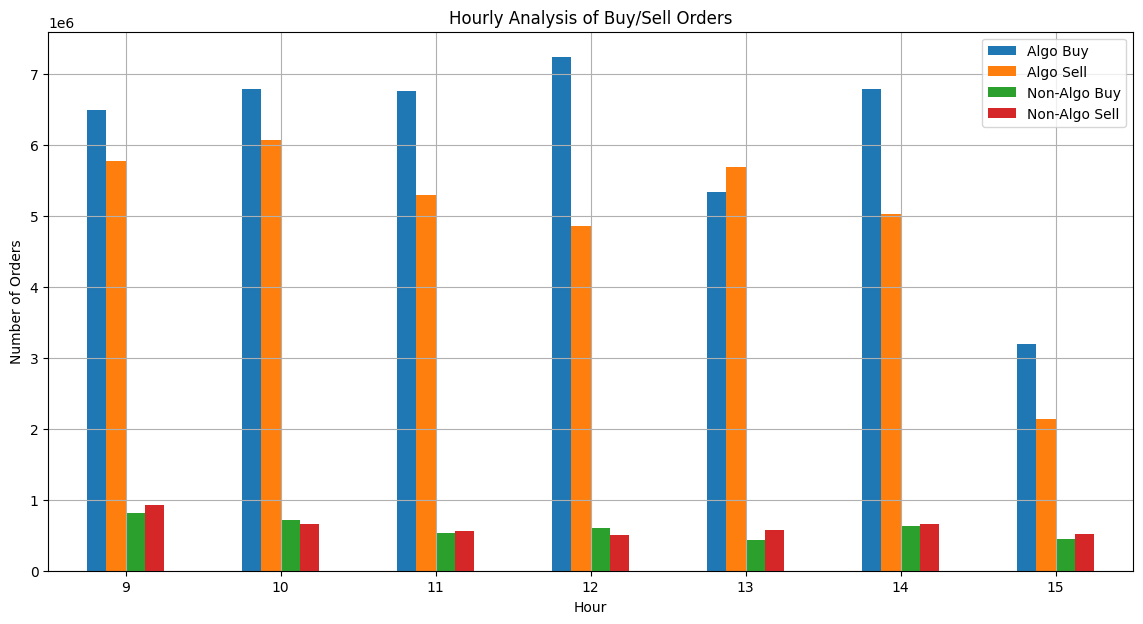

Algo Indicator           Hour             0                            1  \
Buy/Sell Indicator                        B             S              B   
count                7.000000  7.000000e+00  7.000000e+00       7.000000   
mean                12.000000  6.082315e+06  4.975253e+06  596747.285714   
std                  2.160247  1.403135e+06  1.322099e+06  138323.953043   
min                  9.000000  3.197194e+06  2.139284e+06  432283.000000   
25%                 10.500000  5.909366e+06  4.937103e+06  493865.000000   
50%                 12.000000  6.762460e+06  5.290068e+06  601308.000000   
75%                 13.500000  6.783921e+06  5.729948e+06  669126.500000   
max                 15.000000  7.229981e+06  6.063317e+06  817657.000000   

Algo Indicator                                2                
Buy/Sell Indicator              S             B             S  
count                    7.000000      7.000000      7.000000  
mean                625374.571429  10921.714286

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Path to save hourly aggregates
agg_path = '/content/drive/My Drive/hourly_aggregates'

# To ensure the aggregate directory exists
if not os.path.exists(agg_path):
    os.makedirs(agg_path)

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to process each segmented chunk file for hourly aggregation
def aggregate_hourly(file_path):
    chunk_df = pd.read_csv(file_path)

    # To handle non-finite values in 'Transaction Time'
    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)

    # Convert to datetime
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Extracting the hour
    chunk_df['Hour'] = chunk_df['Transaction Time'].dt.hour

    # Filtering hours between 9 and 15
    chunk_df = chunk_df[(chunk_df['Hour'] >= 9) & (chunk_df['Hour'] <= 15)]

    # Ensuring 'Algo Indicator' and 'Buy/Sell Indicator' are in the correct format
    chunk_df['Algo Indicator'] = chunk_df['Algo Indicator'].astype(int)
    chunk_df['Buy/Sell Indicator'] = chunk_df['Buy/Sell Indicator'].astype(str)

    # Grouping by hour, algo indicator, and buy/sell indicator to get the order counts
    hourly_data = chunk_df.groupby(['Hour', 'Algo Indicator', 'Buy/Sell Indicator']).size().reset_index(name='Order Count')

    # Pivoting the data to get the desired format
    hourly_pivot = hourly_data.pivot_table(index='Hour', columns=['Algo Indicator', 'Buy/Sell Indicator'], values='Order Count', fill_value=0)

    return hourly_pivot

# An empty DataFrame to store combined results
combined_aggregates = pd.DataFrame()

# Processing each segmented chunk file and aggregate hourly data
for chunk_file in os.listdir(segmented_path):
    file_path = os.path.join(segmented_path, chunk_file)
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        hourly_pivot = aggregate_hourly(file_path)
        combined_aggregates = pd.concat([combined_aggregates, hourly_pivot], axis=0, ignore_index=False)
        del hourly_pivot
        gc.collect()

# Combining the results by grouping and summing
final_aggregates = combined_aggregates.groupby('Hour').sum().reset_index()

# summary statistics
summary_stats = final_aggregates.describe()

# Plotting the aggregated data
fig, ax = plt.subplots(figsize=(14, 7))
final_aggregates.plot(kind='bar', x='Hour', y=[(0, 'B'), (0, 'S'), (1, 'B'), (1, 'S')], ax=ax)

ax.set_xlabel('Hour')
ax.set_ylabel('Number of Orders')
ax.set_title('Hourly Analysis of Buy/Sell Orders')
ax.legend(['Algo Buy', 'Algo Sell', 'Non-Algo Buy', 'Non-Algo Sell'])
ax.grid(True)

plt.xticks(rotation=0)
plt.show()

print(summary_stats)


## Aggregating in 15-Minute Intervals:

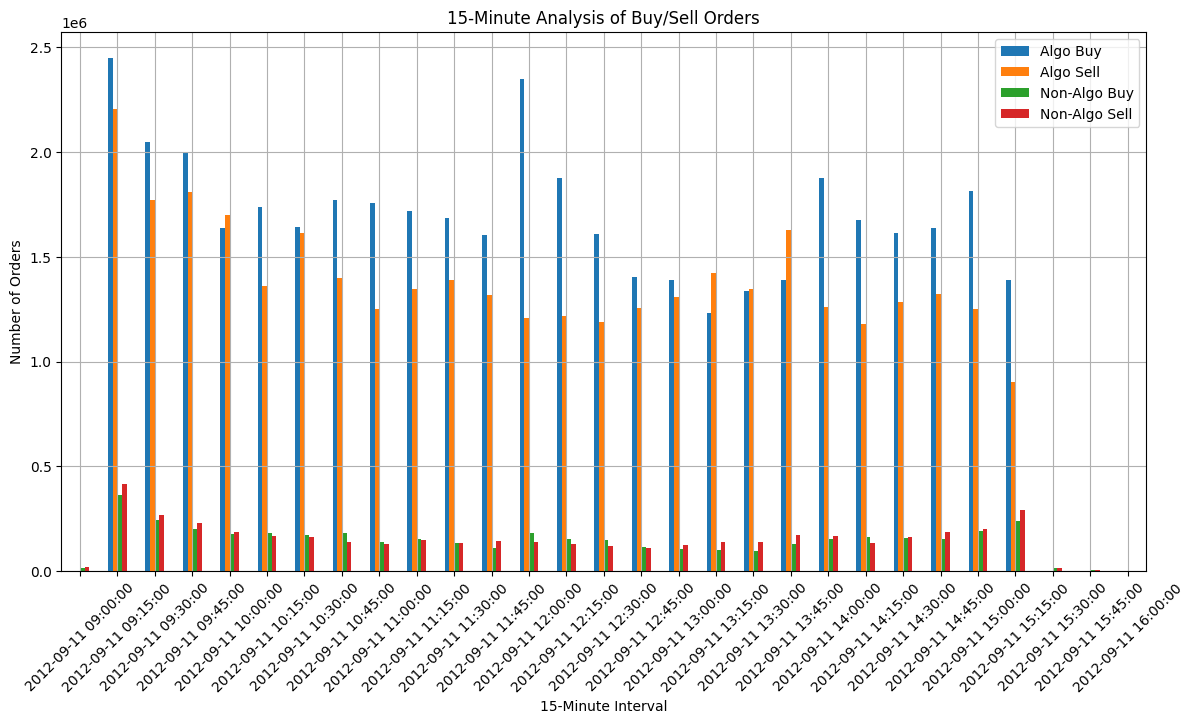

Order Type                                  15min          Algo                \
Buy/Sell Indicator                                            B             S   
count                                          29  2.900000e+01  2.900000e+01   
mean                2012-09-11 12:29:59.999999744  1.470781e+06  1.204400e+06   
min                           2012-09-11 09:00:00  0.000000e+00  0.000000e+00   
25%                           2012-09-11 10:45:00  1.389238e+06  1.208352e+06   
50%                           2012-09-11 12:30:00  1.638895e+06  1.305834e+06   
75%                           2012-09-11 14:15:00  1.770718e+06  1.400189e+06   
max                           2012-09-11 16:00:00  2.450402e+06  2.206383e+06   
std                                           NaN  6.566641e+05  5.481153e+05   

Order Type               Non-Algo                 
Buy/Sell Indicator              B              S  
count                   29.000000      29.000000  
mean                144042.517241  1

In [ ]:
# Function to process each segmented chunk file for 15-minute aggregation
def aggregate_15min(file_path):
    chunk_df = pd.read_csv(file_path)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)

    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Extracting 15-minute interval
    chunk_df['15min'] = chunk_df['Transaction Time'].dt.floor('15T')

    # Defining Algo and Non-Algo based on Algo Indicator
    chunk_df['Order Type'] = chunk_df['Algo Indicator'].apply(lambda x: 'Algo' if x in [0, 2] else 'Non-Algo')

    # To ensure 'Buy/Sell Indicator' is in the correct format
    chunk_df['Buy/Sell Indicator'] = chunk_df['Buy/Sell Indicator'].astype(str)

    # Grouping by 15-minute intervals, order type, and buy/sell indicator to get the order counts
    min15_data = chunk_df.groupby(['15min', 'Order Type', 'Buy/Sell Indicator']).size().reset_index(name='Order Count')

    # Pivoting the data to get the desired format
    min15_pivot = min15_data.pivot_table(index='15min', columns=['Order Type', 'Buy/Sell Indicator'], values='Order Count', fill_value=0)

    return min15_pivot

combined_aggregates = pd.DataFrame()

# Process each segmented chunk file and aggregate 15-minute data
for chunk_file in os.listdir(segmented_path):
    file_path = os.path.join(segmented_path, chunk_file)
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        min15_pivot = aggregate_15min(file_path)
        combined_aggregates = pd.concat([combined_aggregates, min15_pivot], axis=0, ignore_index=False)
        del min15_pivot
        gc.collect()

# Combine the results by grouping and summing
final_aggregates = combined_aggregates.groupby('15min').sum().reset_index()
summary_stats = final_aggregates.describe()

# Plotting the aggregated data
fig, ax = plt.subplots(figsize=(14, 7))
final_aggregates.plot(kind='bar', x='15min', y=[('Algo', 'B'), ('Algo', 'S'), ('Non-Algo', 'B'), ('Non-Algo', 'S')], ax=ax)

ax.set_xlabel('15-Minute Interval')
ax.set_ylabel('Number of Orders')
ax.set_title('15-Minute Analysis of Buy/Sell Orders')
ax.legend(['Algo Buy', 'Algo Sell', 'Non-Algo Buy', 'Non-Algo Sell'])
ax.grid(True)

plt.xticks(rotation=45)
plt.show()

print(summary_stats)


## Plot of Algo and Non Algo orders in 15 minute bucket basis

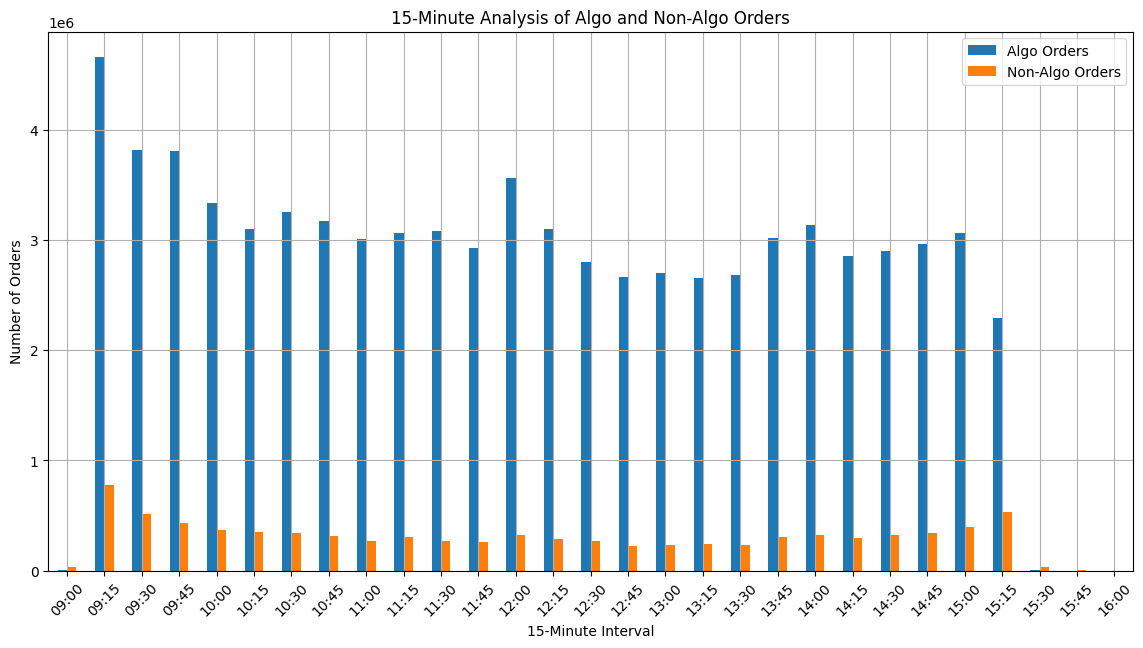

Order Type                          15min          Algo       Non-Algo
count                                  29  2.900000e+01      29.000000
mean        2012-09-11 12:29:59.999999744  2.675181e+06  294995.034483
min                   2012-09-11 09:00:00  0.000000e+00       3.000000
25%                   2012-09-11 10:45:00  2.682829e+06  237881.000000
50%                   2012-09-11 12:30:00  3.006426e+06  300159.000000
75%                   2012-09-11 14:15:00  3.133727e+06  340046.000000
max                   2012-09-11 16:00:00  4.656785e+06  776053.000000
std                                   NaN  1.173689e+06  158475.314533


In [ ]:
# Path to save 15-minute aggregates
agg_path = '/content/drive/My Drive/15min_aggregates'

if not os.path.exists(agg_path):
    os.makedirs(agg_path)

# Function to process each segmented chunk file for 15-minute aggregation
def aggregate_15min(file_path):
    chunk_df = pd.read_csv(file_path)

    # To handle non-finite values in 'Transaction Time'
    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    chunk_df['15min'] = chunk_df['Transaction Time'].dt.floor('15T')
    chunk_df['Order Type'] = chunk_df['Algo Indicator'].apply(lambda x: 'Algo' if x in [0, 2] else 'Non-Algo')

    # Grouping by 15-minute intervals and order type to get the order counts
    min15_data = chunk_df.groupby(['15min', 'Order Type']).size().reset_index(name='Order Count')
    min15_pivot = min15_data.pivot_table(index='15min', columns='Order Type', values='Order Count', fill_value=0)

    return min15_pivot

combined_aggregates = pd.DataFrame()
for chunk_file in os.listdir(segmented_path):
    file_path = os.path.join(segmented_path, chunk_file)
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        min15_pivot = aggregate_15min(file_path)
        combined_aggregates = pd.concat([combined_aggregates, min15_pivot], axis=0, ignore_index=False)
        del min15_pivot
        gc.collect()

final_aggregates = combined_aggregates.groupby('15min').sum().reset_index()

summary_stats = final_aggregates.describe()

fig, ax = plt.subplots(figsize=(14, 7))

final_aggregates.plot(kind='bar', x='15min', y=['Algo', 'Non-Algo'], ax=ax)

ax.set_xlabel('15-Minute Interval')
ax.set_ylabel('Number of Orders')
ax.set_title('15-Minute Analysis of Algo and Non-Algo Orders')
ax.legend(['Algo Orders', 'Non-Algo Orders'])
ax.grid(True)
ax.set_xticklabels([label.strftime('%H:%M') for label in final_aggregates['15min']], rotation=45)

plt.xticks(rotation=45)
plt.show()

print(summary_stats)


# Checkpoint 5: Order Imbalance computation and visualization

In [ ]:
import pandas as pd
import os

# Function to segment each row based on defined lengths
def segment_row(row, lengths):
    positions = [sum(lengths[:i]) for i in range(len(lengths) + 1)]
    return [row[positions[i]:positions[i+1]].strip() for i in range(len(lengths))]

# Path to load processed chunks and to save segmented chunks
load_path = '/content/drive/My Drive/processed_chunks'
segmented_path = '/content/drive/My Drive/segmented_chunks'

# Initializing the column names and segment lengths
columns = ["Record Indicator", "Segment", "Order Number", "Transaction Time",
           "Buy/Sell Indicator", "Activity Type", "Symbol", "Series", "Volume Disclosed",
           "Volume Original", "Limit Price", "Trigger Price", "Market Order Flag",
           "Stop Loss Flag", "IO Flag", "Algo Indicator", "Client Identity Flag"]
segment_lengths = [2, 4, 16, 14, 1, 1, 10, 2, 8, 8, 8, 8, 1, 1, 1, 1, 1]

# Processing and segmenting data in smaller chunks
chunk_size = 100000  # Number of rows per chunk
for chunk_file in os.listdir(load_path):
    if chunk_file.startswith('chunk_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(load_path, chunk_file)
        chunk_iter = pd.read_csv(chunk_path, header=None, chunksize=chunk_size)

        for i, chunk in enumerate(chunk_iter):
            segmented_data = [segment_row(row[0], segment_lengths) for row in chunk.itertuples(index=False)]

            chunk_df = pd.DataFrame(segmented_data, columns=columns)

            chunk_df.to_csv(os.path.join(segmented_path, f"segmented_{chunk_file}_{i}.csv"), index=False)

print("All chunks have been segmented and saved.")


KeyboardInterrupt: 

## Calculating the order imbalance and storing the aggregated results in a dataframe

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)

    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 15-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']
    return imbalance

# Initializing an empty DataFrame to store aggregated results
aggregated_imbalance = pd.DataFrame()

# Path to the segmented files
chunked_path = '/content/drive/My Drive/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.csv'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_imbalance = process_chunk(chunk_file_path)

        if chunk_imbalance.empty:
            continue

        if aggregated_imbalance.empty:
            aggregated_imbalance = chunk_imbalance
        else:
            aggregated_imbalance = aggregated_imbalance.merge(chunk_imbalance, on='5min Interval', how='outer', suffixes=('', '_new'))
            aggregated_imbalance['Order Imbalance'] = aggregated_imbalance['Order Imbalance'].fillna(0) + aggregated_imbalance['Order Imbalance_new'].fillna(0)
            aggregated_imbalance.drop(columns=['Order Imbalance_new'], inplace=True)

# Save the aggregated results to a CSV file
aggregated_imbalance.to_csv('order_imbalance.csv', index=False)


## Observing the trend of order imbalance over time (5 min intervals)

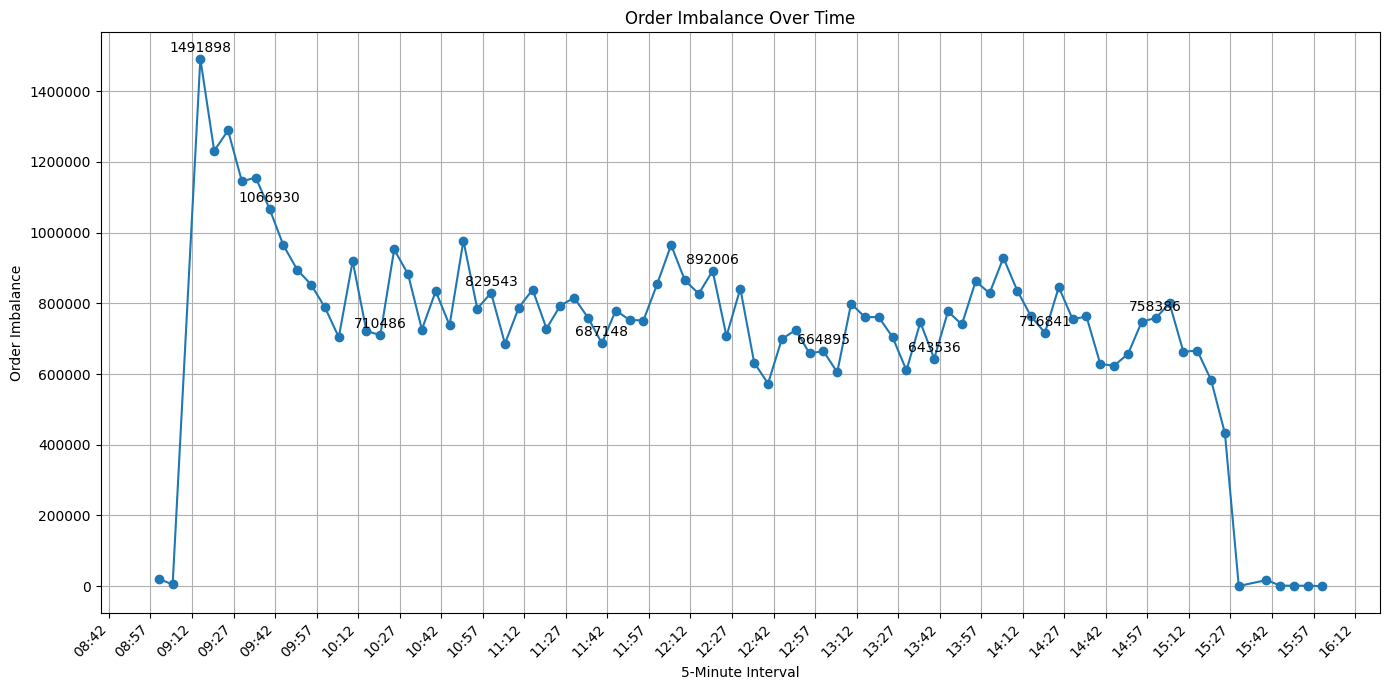

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Loading the order imbalances from the CSV file
aggregated_imbalance = pd.read_csv('order_imbalance.csv')

# Converting '5min Interval' to datetime for proper plotting
aggregated_imbalance['5min Interval'] = pd.to_datetime(aggregated_imbalance['5min Interval'])

# Sort the DataFrame by '5min Interval'
aggregated_imbalance = aggregated_imbalance.sort_values(by='5min Interval')

# Function to format y-axis labels
def plain_format(x, pos):
    return '%1.0f' % x

# Ploting the order imbalances
plt.figure(figsize=(14, 7))
plt.plot(aggregated_imbalance['5min Interval'], aggregated_imbalance['Order Imbalance'], marker='o', linestyle='-')

# Formatting the x-axis to show 5-minute intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Using the custom formatter for the y-axis to show plain numbers
plt.gca().yaxis.set_major_formatter(FuncFormatter(plain_format))

# Titles and labels
plt.title('Order Imbalance Over Time')
plt.xlabel('5-Minute Interval')
plt.ylabel('Order Imbalance')
plt.grid(True)

# Annotating fewer points with imbalance values (every 3rd point)
for i, row in aggregated_imbalance.iterrows():
    if i % 8 == 4:  # Change this value to adjust the frequency of annotations
        plt.annotate(f"{int(row['Order Imbalance'])}",
                     (row['5min Interval'], row['Order Imbalance']),
                     textcoords="offset points",
                     xytext=(0, 5),
                     ha='center')

plt.tight_layout()

plt.show()


In [ ]:
data = pd.read_csv('order_imbalance.csv')
data

,5min Interval,Order Imbalance
0,2012-09-11 09:20:00,1231382.0
1,2012-09-11 09:25:00,1288950.0
2,2012-09-11 09:30:00,1145285.0
3,2012-09-11 09:35:00,1155509.0
4,2012-09-11 09:40:00,1066930.0
...,...,...
78,2012-09-11 15:40:00,17227.0
79,2012-09-11 15:45:00,1530.0
80,2012-09-11 15:50:00,1228.0
81,2012-09-11 15:55:00,1226.0


RIGHT CODE

5 Min Basis


In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    # Drop rows with NaN values in 'Limit Price'
    chunk_df = chunk_df.dropna(subset=['Limit Price'])

    # Convert 'Limit Price' from paise to rupees
    chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 15-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']

    # Aggregating other liquidity measures
    volume_original = chunk_df.groupby('5min Interval')['Volume Original'].sum().reset_index()
    limit_price_mean = chunk_df.groupby('5min Interval')['Limit Price'].mean().reset_index()

    # Merge all metrics into one DataFrame
    metrics = imbalance.merge(volume_original, on='5min Interval', how='left')
    metrics = metrics.merge(limit_price_mean, on='5min Interval', how='left')

    return metrics


<ipython-input-19-0e0503f8e095>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],


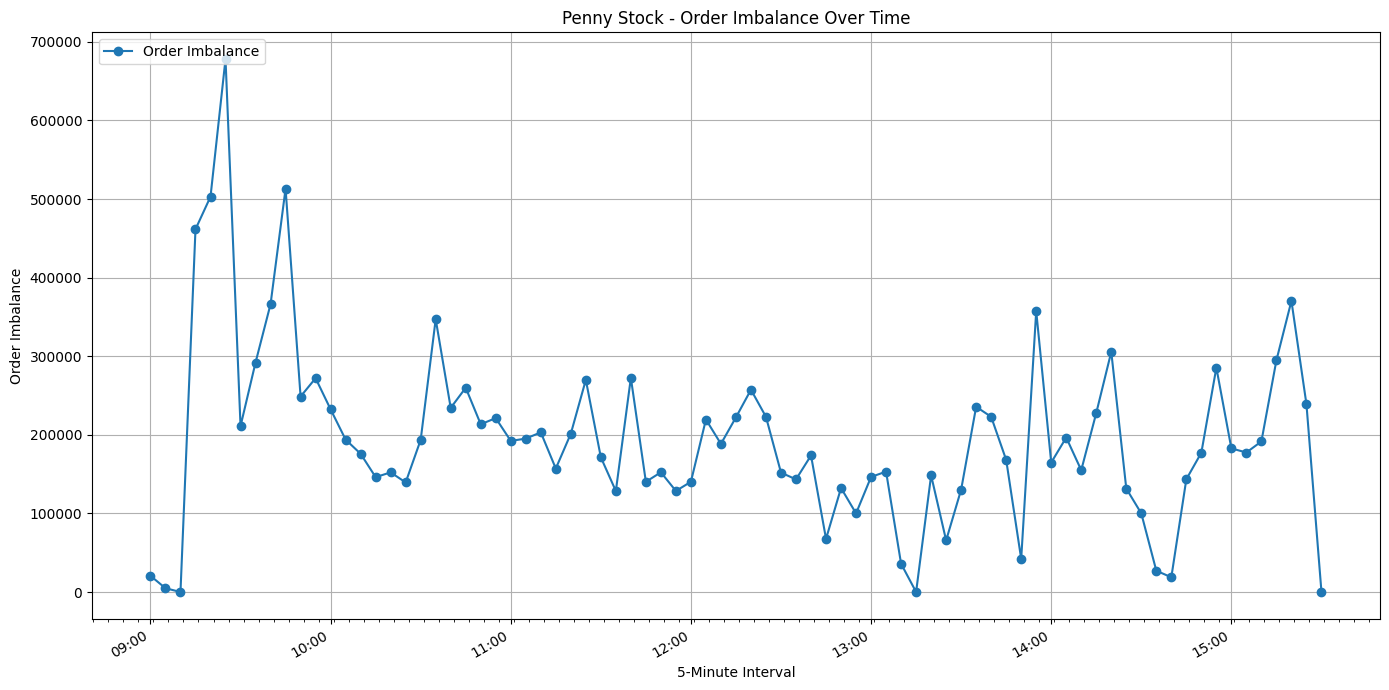

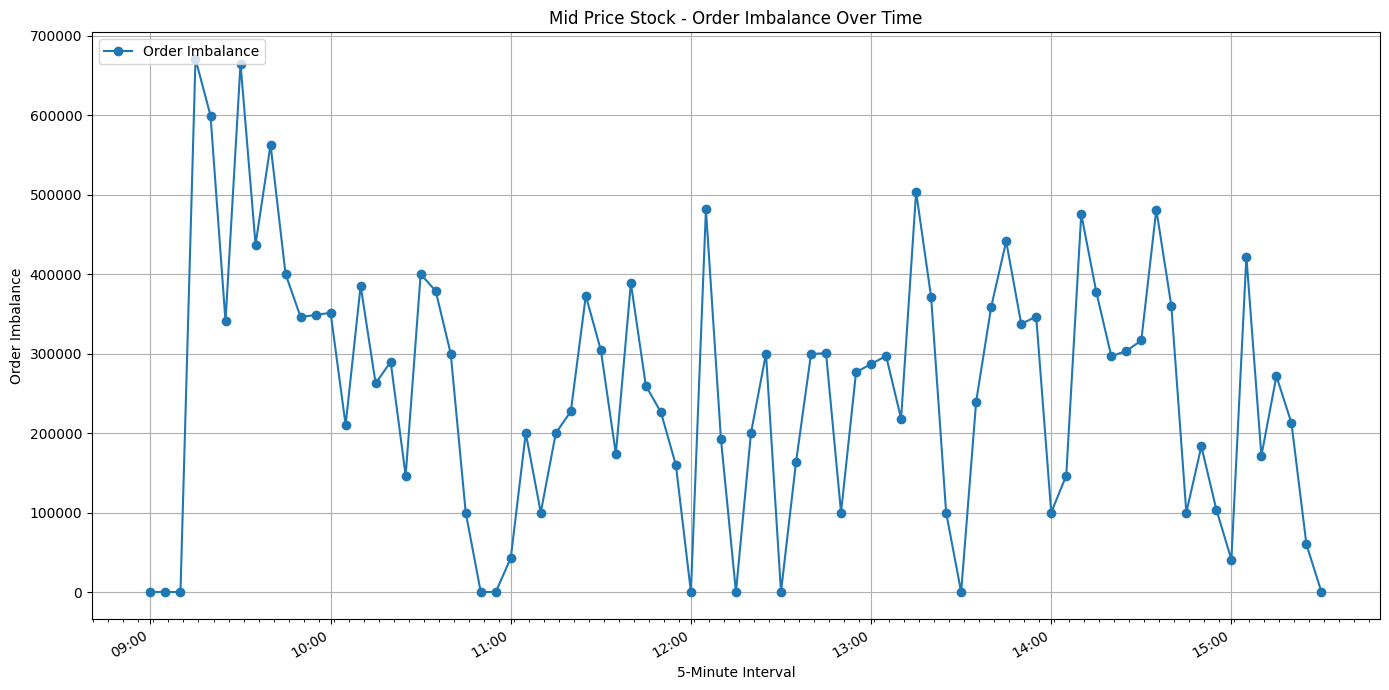

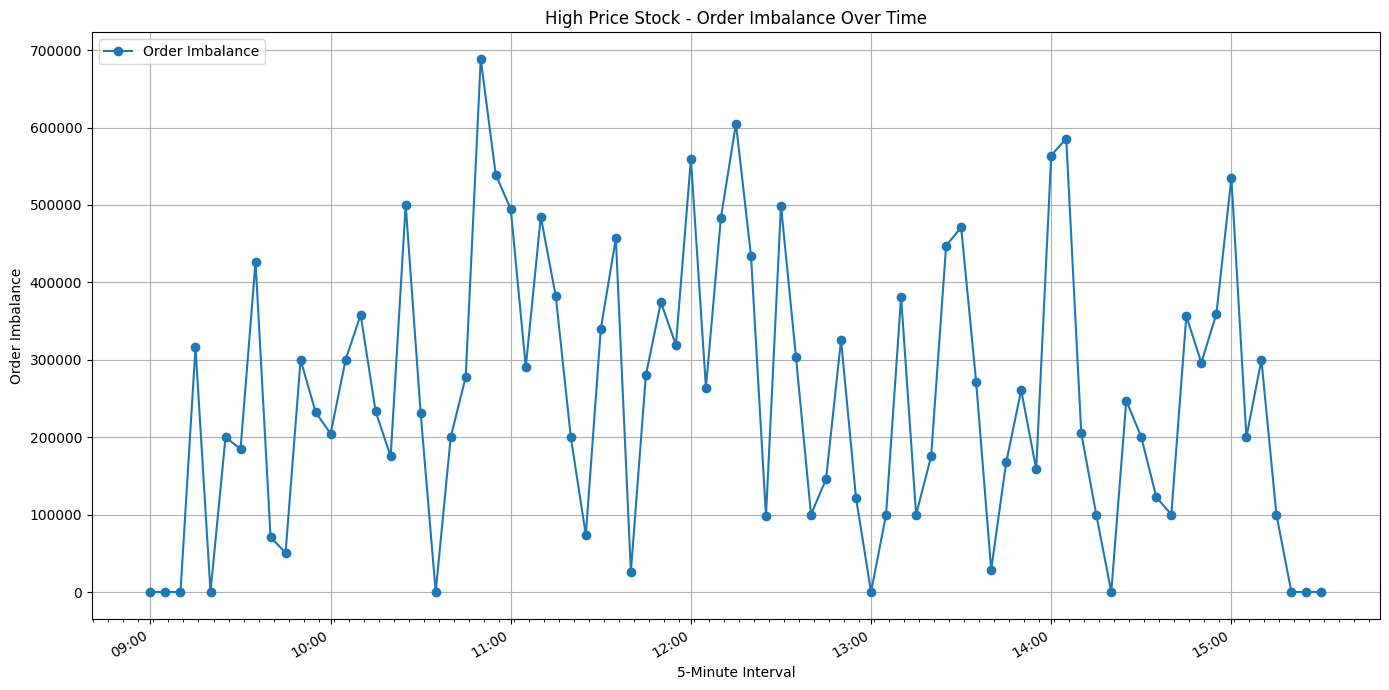

In [ ]:
# Initializing an empty DataFrame to store aggregated results
aggregated_metrics = pd.DataFrame()

# Path to the segmented files
chunked_path = '/content/drive/My Drive/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.csv'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_metrics = process_chunk(chunk_file_path)

        if chunk_metrics.empty:
            continue

        if aggregated_metrics.empty:
            aggregated_metrics = chunk_metrics
        else:
            aggregated_metrics = pd.concat([aggregated_metrics, chunk_metrics])

# Remove outliers based on 'Limit Price'
filtered_df = aggregated_metrics[(aggregated_metrics['Limit Price'] > aggregated_metrics['Limit Price'].quantile(0.05)) &
                                 (aggregated_metrics['Limit Price'] < aggregated_metrics['Limit Price'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['Limit Price'].quantile([0.33, 0.66])

filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating metrics for each category
liquidity_measures = filtered_df.groupby(['Stock Category', pd.Grouper(key='5min Interval', freq='5T')]).agg({
    'Order Imbalance': 'sum',
    'Volume Original': 'sum',
    'Limit Price': 'mean'
}).reset_index()

# Save the aggregated results to a CSV file
liquidity_measures.to_csv('liquidity_measures.csv', index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.plot(category_df['5min Interval'], category_df['Order Imbalance'], marker='o', linestyle='-', label='Order Imbalance')
    ax.set_xlabel('5-Minute Interval')
    ax.set_ylabel('Order Imbalance')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))
    ax.set_title(f'{stock_category} - Order Imbalance Over Time')
    ax.legend(loc='upper left')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)

LIQUIDITY ANALYSIS

colab gemini suggested changes

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert volume strings to integers
def convert_volume(volume_str):
    return int(volume_str)

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    # Drop rows with NaN values in 'Limit Price'
    chunk_df = chunk_df.dropna(subset=['Limit Price'])

    # Convert 'Limit Price' from paise to rupees
    chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Convert 'Volume Disclosed' and 'Volume Original' from strings to integers
    chunk_df['Volume Disclosed'] = chunk_df['Volume Disclosed'].apply(convert_volume)
    chunk_df['Volume Original'] = chunk_df['Volume Original'].apply(convert_volume)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']

    # Aggregating other liquidity measures
    volume_original = chunk_df.groupby('5min Interval')['Volume Original'].sum().reset_index()
    total_liquidity = (chunk_df['Volume Original'] * chunk_df['Limit Price']).groupby(chunk_df['5min Interval']).sum().reset_index()
    limit_price_mean = chunk_df.groupby('5min Interval')['Limit Price'].mean().reset_index() # Calculate mean Limit Price for each interval

    # Merge all metrics into one DataFrame
    metrics = imbalance.merge(volume_original, on='5min Interval', how='left')
    metrics = metrics.merge(total_liquidity, on='5min Interval', how='left', suffixes=('', '_TotalLiquidity'))
    metrics = metrics.merge(limit_price_mean, on='5min Interval', how='left') # Merge Limit Price into metrics

    return metrics

<ipython-input-13-7ea32534ada5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],


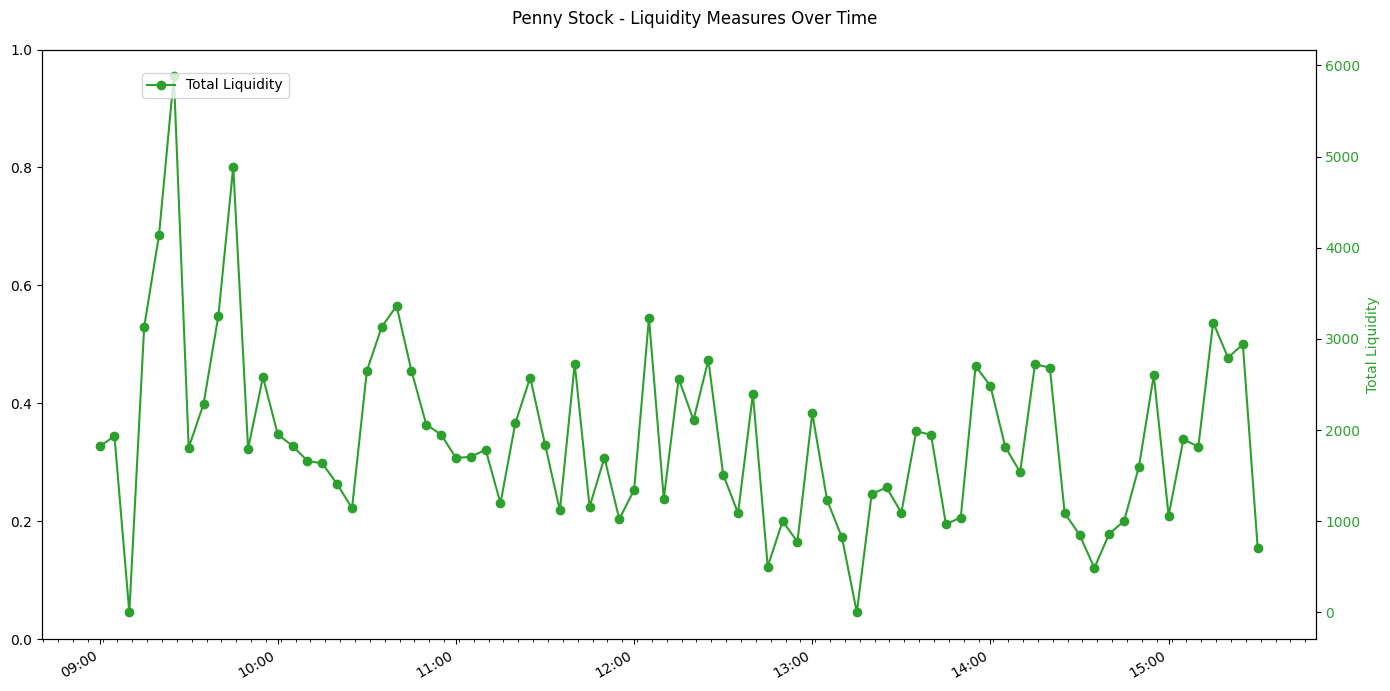

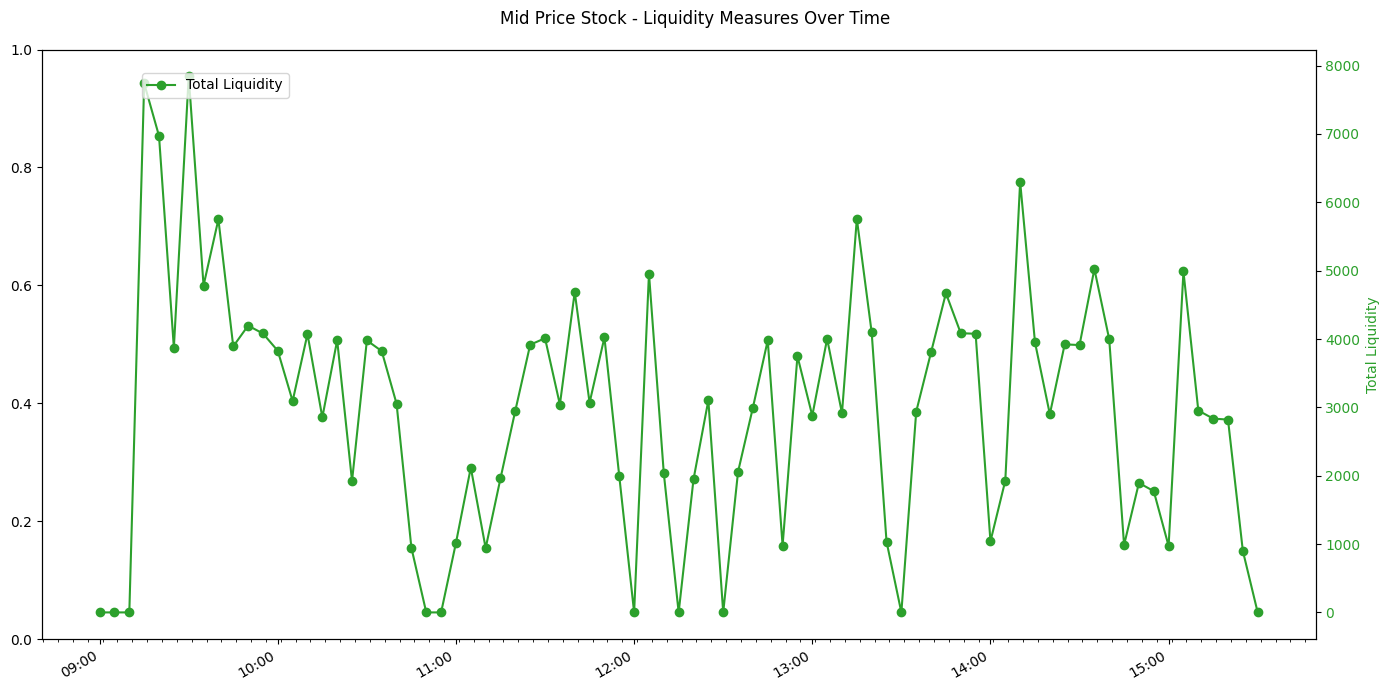

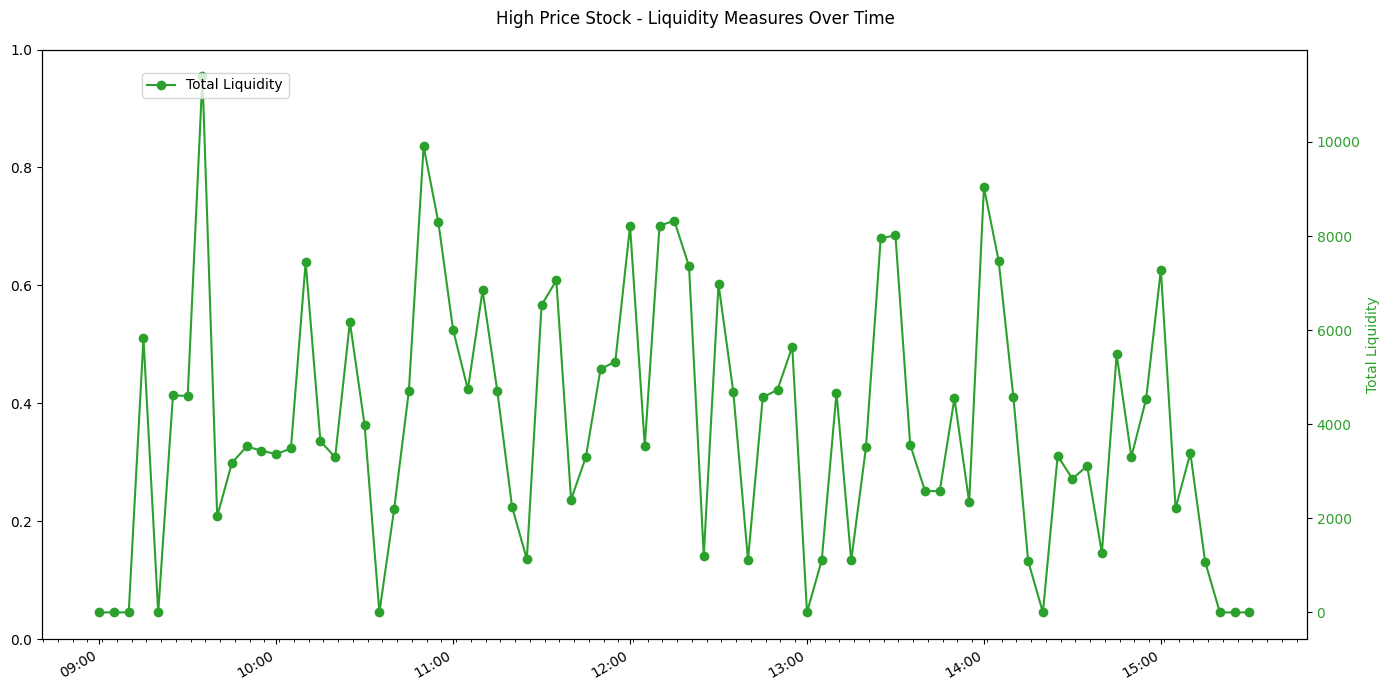

In [ ]:
# Initializing an empty DataFrame to store aggregated results
aggregated_metrics = pd.DataFrame()

# Path to the segmented files
chunked_path = '/content/drive/My Drive/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.csv'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_metrics = process_chunk(chunk_file_path)

        if chunk_metrics.empty:
            continue

        if aggregated_metrics.empty:
            aggregated_metrics = chunk_metrics
        else:
            aggregated_metrics = pd.concat([aggregated_metrics, chunk_metrics])

# Remove outliers based on 'Limit Price'
filtered_df = aggregated_metrics[(aggregated_metrics['Limit Price'] > aggregated_metrics['Limit Price'].quantile(0.05)) &
                                 (aggregated_metrics['Limit Price'] < aggregated_metrics['Limit Price'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['Limit Price'].quantile([0.33, 0.66])
filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating metrics for each category
liquidity_measures = filtered_df.groupby(['Stock Category', pd.Grouper(key='5min Interval', freq='5T')]).agg({
    'Order Imbalance': 'sum',
    'Volume Original': 'sum',
    'Limit Price': 'sum'  # Change 'Limit Price_TotalLiquidity' to 'Limit Price'
}).reset_index()

# Rename columns for clarity
liquidity_measures.rename(columns={
    'Volume Original': 'Total Volume',
    'Limit Price': 'Total Liquidity'
}, inplace=True)

# Save the aggregated results to a CSV file
liquidity_measures.to_csv('liquidity_measures.csv', index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # ax1.plot(category_df['5min Interval'], category_df['Order Imbalance'], marker='o', linestyle='-', label='Order Imbalance', color='tab:blue')
    # ax1.set_xlabel('5-Minute Interval')
    # ax1.set_ylabel('Order Imbalance', color='tab:blue')
    # ax1.tick_params(axis='y', labelcolor='tab:blue')
    # ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    # ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # plt.gcf().autofmt_xdate()
    # ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))

    ax2 = ax1.twinx()
    ax2.plot(category_df['5min Interval'], category_df['Total Liquidity'], marker='o', linestyle='-', label='Total Liquidity', color='tab:green')
    ax2.set_ylabel('Total Liquidity', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))

    fig.suptitle(f'{stock_category} - Liquidity Measures Over Time')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)


In [ ]:
aggregated_metrics.head()

,5min Interval,Order Imbalance,Volume Original,0
0,2012-09-11 09:20:00,100000,38341302,2.208160e+10
0,2012-09-11 09:20:00,100000,40011131,2.310899e+10
0,2012-09-11 09:20:00,16335,8030748,3.779449e+09
1,2012-09-11 09:25:00,83665,37274144,1.698791e+10
0,2012-09-11 09:25:00,100000,38901160,2.180371e+10


<ipython-input-4-2037a4a657a2>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Stock Category'] = pd.cut(filtered_df['High'],


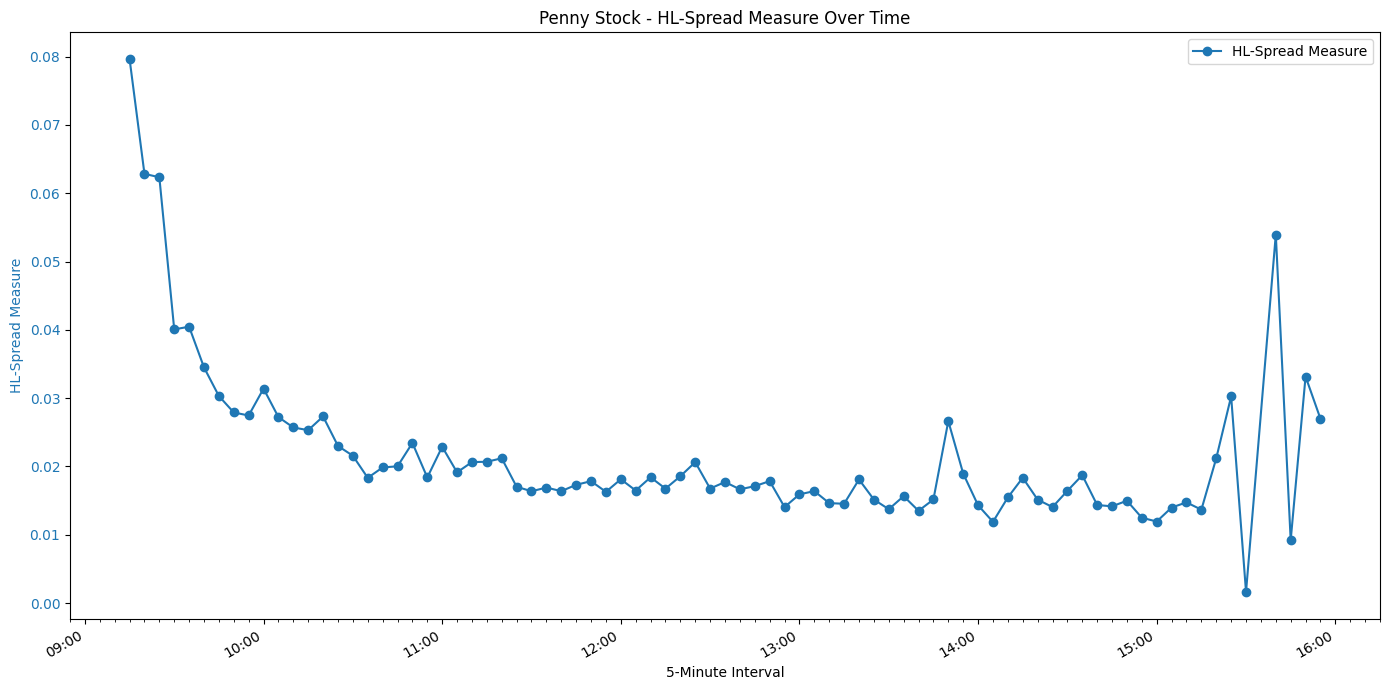

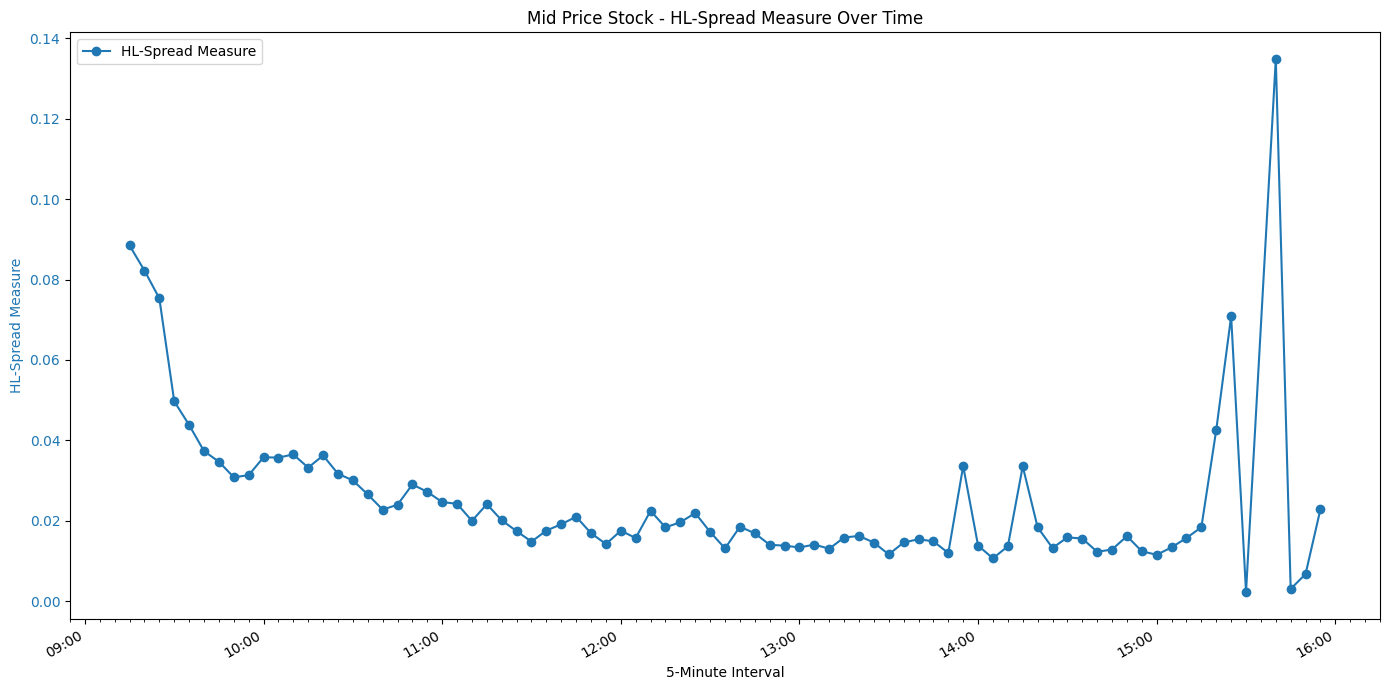

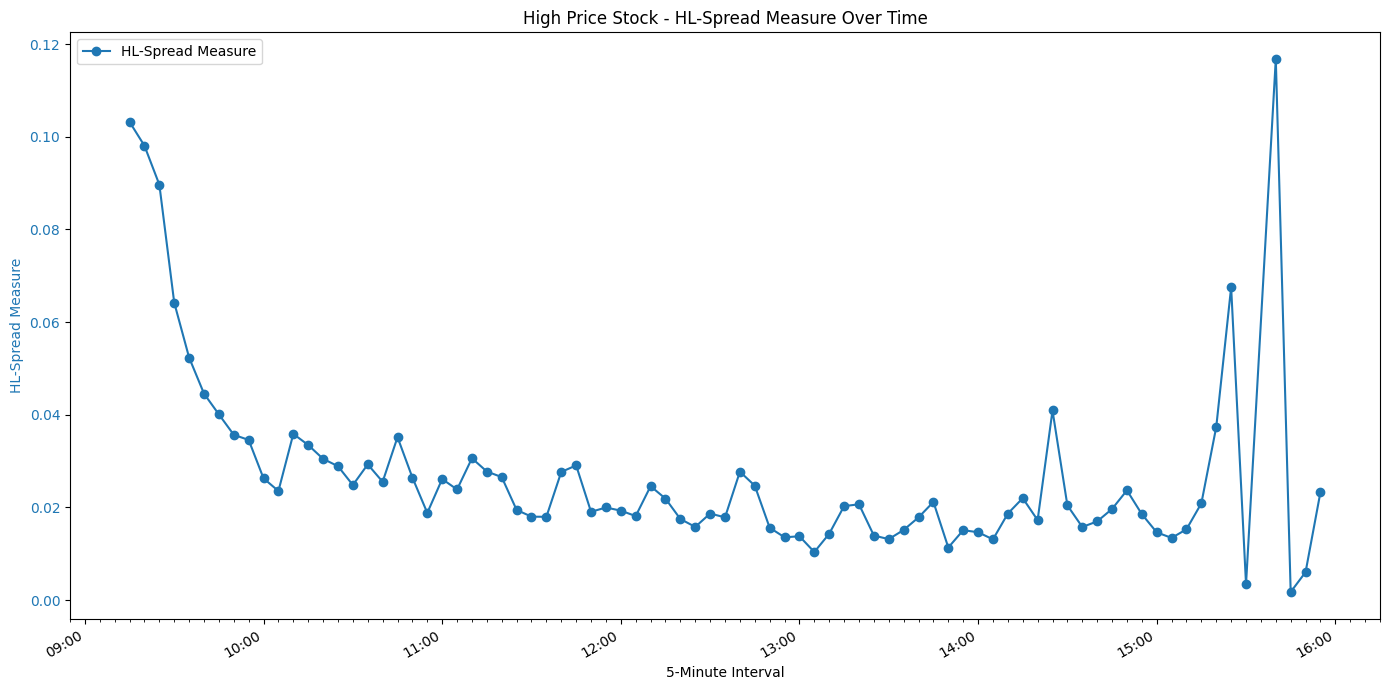

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to compute HL-Spread Measure
def calculate_hl_spread(high, low):
    if low == 0:  # Avoid division by zero
        return np.nan
    a = np.log(high / low) / (2 * np.sqrt(2 * np.log(2)))
    hl_spread = (2 * (np.exp(a) - 1)) / (1 + np.exp(a))
    return hl_spread

# Initialize DataFrame to store results
all_data = pd.DataFrame()

segmented_path = '/content/drive/My Drive/segmented_chunks'

# Process each segmented chunk
for chunk_file in os.listdir(segmented_path):
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(segmented_path, chunk_file)
        df = pd.read_csv(chunk_path)

        # Drop rows with NaN values in 'Limit Price'
        df = df.dropna(subset=['Limit Price'])

        # Convert 'Limit Price' from paise to rupees
        df['Limit Price'] = df['Limit Price'].apply(convert_price)

        # Convert 'Transaction Time' to datetime
        df['Transaction Time'] = pd.to_numeric(df['Transaction Time'], errors='coerce')
        df = df.dropna(subset=['Transaction Time'])
        df['Transaction Time'] = df['Transaction Time'].astype(int)
        df['Transaction Time'] = df['Transaction Time'].apply(jiffies_to_datetime)

        # Drop rows with NaN values in 'Limit Price'
        df = df.dropna(subset=['Limit Price'])

        # Convert 'Volume Original' from strings to integers
        df['Volume Original'] = df['Volume Original'].apply(int)

        # Convert 'Transaction Time' to 5-minute intervals
        df['5min Interval'] = df['Transaction Time'].dt.floor('5T')

        # Compute High and Low Prices for each 5-minute interval
        interval_data = df.groupby(['5min Interval', 'Symbol']).agg({
            'Limit Price': ['max', 'min'],
            'Volume Original': 'sum'
        }).reset_index()

        # Rename columns for easier access
        interval_data.columns = ['5min Interval', 'Symbol', 'High', 'Low', 'Volume Original']

        # Calculate HL-Spread Measure
        interval_data['HL-Spread Measure'] = interval_data.apply(lambda row: calculate_hl_spread(row['High'], row['Low']), axis=1)

        # Append to all_data
        all_data = pd.concat([all_data, interval_data])

# Remove outliers based on 'Limit Price'
filtered_df = all_data[(all_data['High'] > all_data['High'].quantile(0.05)) &
                       (all_data['High'] < all_data['High'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['High'].quantile([0.33, 0.66])
filtered_df['Stock Category'] = pd.cut(filtered_df['High'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating HL-Spread Measure for each category and interval
liquidity_measures = filtered_df.groupby(['Stock Category', '5min Interval']).agg({
    'HL-Spread Measure': 'mean'
}).reset_index()

# Filter out intervals before 9:15
liquidity_measures = liquidity_measures[liquidity_measures['5min Interval'] >= '2012-09-11 09:15:00']

# Save the aggregated results to a CSV file
save_path = '/content/liquidity_measures'
if not os.path.exists(save_path):
    os.makedirs(save_path)
liquidity_measures.to_csv(os.path.join(save_path, 'hl_spread_measures_by_category.csv'), index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(category_df['5min Interval'], category_df['HL-Spread Measure'], marker='o', linestyle='-', label='HL-Spread Measure', color='tab:blue')
    ax1.set_xlabel('5-Minute Interval')
    ax1.set_ylabel('HL-Spread Measure', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))

    plt.title(f'{stock_category} - HL-Spread Measure Over Time')
    plt.tight_layout()
    plt.legend()
    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)


testing 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called df
# Applying rolling mean with a window of 5 for smoothing
aggregated_results['Order Imbalance Smoothed'] = aggregated_results['Order Imbalance'].rolling(window=5).mean()
aggregated_results['Total Liquidity Smoothed'] = aggregated_results['Total Liquidity'].rolling(window=5).mean()

# Plotting the smoothed data
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
for category in df['Stock Category'].unique():
    subset = df[df['Stock Category'] == category]
    plt.plot(subset['15-Minute Interval'], subset['Order Imbalance Smoothed'], label=category)
plt.title('Smoothed Order Imbalance Over Time by Stock Category')
plt.xlabel('15-Minute Interval')
plt.ylabel('Order Imbalance')
plt.legend()

plt.subplot(2, 1, 2)
for category in df['Stock Category'].unique():
    subset = df[df['Stock Category'] == category]
    plt.plot(subset['15-Minute Interval'], subset['Total Liquidity Smoothed'], label=category)
plt.title('Smoothed Total Liquidity Over Time by Stock Category')
plt.xlabel('15-Minute Interval')
plt.ylabel('Total Liquidity')
plt.legend()

plt.tight_layout()
plt.show()


KeyError: 'Order Imbalance'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import os

# Helper functions for processing
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

def convert_jiffies_to_datetime(jiffies):
    base_date = pd.Timestamp('1980-01-01')
    seconds = jiffies / 65536
    return base_date + pd.to_timedelta(seconds, unit='s')

def process_chunk(chunk_file):
    print(f"Processing file: {chunk_file}")
    chunk_df = pd.read_csv(chunk_file)
    print("Initial chunk data:")
    print(chunk_df.head())

    # Replace NaN values in 'Trigger Price' with '00000000'
    chunk_df['Trigger Price'].fillna('00000000', inplace=True)

    # Convert 'Trigger Price' from paise to rupees
    chunk_df['Stock Price'] = chunk_df['Trigger Price'].apply(convert_price)

    # Convert 'Transaction Time' from jiffies to datetime
    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(convert_jiffies_to_datetime)

    print("Processed chunk data:")
    print(chunk_df.head())

    return chunk_df

def aggregate_chunk_results(chunk_df):
    print("Aggregating chunk data...")

    # Remove outliers based on 'Stock Price'
    chunk_df = chunk_df[(chunk_df['Stock Price'] > chunk_df['Stock Price'].quantile(0.05)) &
                        (chunk_df['Stock Price'] < chunk_df['Stock Price'].quantile(0.95))]

    # Classify stocks
    stock_price_quantiles = chunk_df['Stock Price'].quantile([0.33, 0.66])

    # Check for NaN quantiles
    if stock_price_quantiles.isnull().any():
        print("Quantiles contain NaN values, skipping chunk.")
        return pd.DataFrame()

    chunk_df['Stock Category'] = pd.cut(chunk_df['Stock Price'],
                                        bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                        labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

    # Calculate liquidity measures
    liquidity_measures = chunk_df.groupby(['Stock Category', pd.Grouper(key='Transaction Time', freq='15T')]).agg({
        'Order Number': 'count',
        'Volume Original': 'sum',
        'Limit Price': 'mean'
    }).reset_index()

    print("Aggregated liquidity measures:")
    print(liquidity_measures.head())

    return liquidity_measures

segmented_path = '/content/drive/MyDrive/segmented_chunks'
chunk_files = [os.path.join(segmented_path, f) for f in os.listdir(segmented_path) if f.endswith('.csv')]

# Initialize an empty DataFrame to store aggregated results
aggregated_results = pd.DataFrame()

for chunk_file in chunk_files:
    processed_chunk = process_chunk(chunk_file)
    if processed_chunk.empty:
        print(f"Processed chunk is empty for file: {chunk_file}")
        continue

    chunk_liquidity_measures = aggregate_chunk_results(processed_chunk)
    if chunk_liquidity_measures.empty:
        print(f"Aggregated results are empty for file: {chunk_file}")
        continue

    if aggregated_results.empty:
        aggregated_results = chunk_liquidity_measures
    else:
        aggregated_results = pd.concat([aggregated_results, chunk_liquidity_measures], ignore_index=True)

print("Final aggregated results:")
print(aggregated_results.head())

if aggregated_results.empty:
    print("Aggregated results are empty, nothing to plot.")
else:
    # Plotting Order Imbalance over time by Stock Category
    plt.figure(figsize=(14, 7))
    for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
        category_df = aggregated_results[aggregated_results['Stock Category'] == category]
        plt.plot(category_df['Transaction Time'], category_df['Order Number'], marker='o', label=category)

    # Formatting the plot
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))
    plt.title('Order Imbalance Over Time by Stock Category')
    plt.xlabel('15-Minute Interval')
    plt.ylabel('Order Imbalance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Total Liquidity over time by Stock Category
    plt.figure(figsize=(14, 7))
    for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
        category_df = aggregated_results[aggregated_results['Stock Category'] == category]
        plt.plot(category_df['Transaction Time'], category_df['Volume Original'], marker='o', label=category)

    # Formatting the plot
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))
    plt.title('Total Liquidity Over Time by Stock Category')
    plt.xlabel('15-Minute Interval')
    plt.ylabel('Total Liquidity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Processing file: /content/drive/MyDrive/segmented_chunks/segmented_chunk_0.csv_15.csv
Initial chunk data:
  Record Indicator Segment      Order Number  Transaction Time  \
0               RM    CASH  2012091100248811    67621526749220   
1               RM    CASH  2012091100244253    67621526749231   
2               RM    CASH  2012091100248810    67621526749238   
3               RM    CASH  2012091100248809    67621526749254   
4               RM    CASH  2012091100246395    67621526749269   

  Buy/Sell Indicator  Activity Type    Symbol Series  Volume Disclosed  \
0                  S              4  JSWSTEEL     EQ                 0   
1                  S              4  JSWSTEEL     EQ                 0   
2                  S              4  JSWSTEEL     EQ                 0   
3                  S              4  JSWSTEEL     EQ                 0   
4                  S              4  JSWSTEEL     EQ                 0   

   Volume Original  Limit Price  Trigger Price Marke

KeyboardInterrupt: 

# Checkpoint 6: T-Test to visulaize order flow differences across the day

## Defining segmentation function

In [ ]:
def segment_data(line, columns, lengths):
    segment = {}
    start = 0
    for col, length in zip(columns, lengths):
        segment[col] = line[start:start+length].strip()
        start += length
    return segment


## Processing each chunk file and segmenting the data

In [ ]:
import os
import csv
import glob

# Paths to the directories
chunk_path = '/content/drive/My Drive/processed_chunks'
segmented_path = '/content/drive/My Drive/segmented_chunks'

# Creating a directory for segmented files if it does not exist
os.makedirs(segmented_path, exist_ok=True)

columns = ["Record Indicator", "Segment", "Order Number", "Transaction Time",
           "Buy/Sell Indicator", "Activity Type", "Symbol", "Series", "Volume Disclosed",
           "Volume Original", "Limit Price", "Trigger Price", "Market Order Flag",
           "Stop Loss Flag", "IO Flag", "Algo Indicator", "Client Identity Flag"]
segment_lengths = [2, 4, 16, 14, 1, 1, 10, 2, 8, 8, 8, 8, 1, 1, 1, 1, 1]

# Function to segment a single line of data
def segment_line(line, columns, lengths):
    segment = {}
    start = 0
    for col, length in zip(columns, lengths):
        segment[col] = line[start:start+length].strip()
        start += length
    return segment

# Function to process each chunk file
def process_chunk_file(chunk_file):
    output_file = os.path.join(segmented_path, os.path.basename(chunk_file))
    with open(chunk_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        writer = csv.DictWriter(outfile, fieldnames=columns)
        writer.writeheader()
        for line in infile:
            segmented_data = segment_line(line.strip(), columns, segment_lengths)
            writer.writerow(segmented_data)

# Processing each chunk file
chunk_files = sorted(glob.glob(os.path.join(chunk_path, 'chunk_*.csv')))

for chunk_file in chunk_files:
    process_chunk_file(chunk_file)


KeyboardInterrupt: 

## Loading and processing the segmented data

In [ ]:
import pandas as pd
import glob
from datetime import datetime, timedelta
import os

# Path to the directory containing the segmented files
segmented_path = '/content/drive/My Drive/segmented_chunks'

# Initializing an empty DataFrame to store the aggregated results
aggregated_data = pd.DataFrame()

# Reading each segmented chunk to compute order imbalances
segmented_files = sorted(glob.glob(os.path.join(segmented_path, 'chunk_*.csv')))

def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

for segmented_file in segmented_files:
    chunk = pd.read_csv(segmented_file)

    # To handle non-finite values in 'Transaction Time'
    chunk['Transaction Time'] = pd.to_numeric(chunk['Transaction Time'], errors='coerce')
    chunk = chunk.dropna(subset=['Transaction Time'])
    chunk['Transaction Time'] = chunk['Transaction Time'].astype(int)
    chunk['Transaction Time'] = chunk['Transaction Time'].apply(jiffies_to_datetime)

    # Sorting by 'Transaction Time'
    chunk.sort_values('Transaction Time', inplace=True)

    # Determining 'Order Type' based on 'Buy/Sell Indicator'
    chunk['Order Type'] = chunk['Buy/Sell Indicator'].apply(lambda x: 'Buy' if x == 'B' else 'Sell')

    # Setting 'Transaction Time' as the index
    chunk.set_index('Transaction Time', inplace=True)

    # Resampling data to 5-minute intervals and calculate buy and sell orders
    resampled_chunk = chunk.resample('5T').apply({
        'Order Type': ['count', lambda x: (x == 'Buy').sum(), lambda x: (x == 'Sell').sum()]
    })

    # Renaming columns for clarity
    resampled_chunk.columns = ['Total Orders', 'Buy Orders', 'Sell Orders']

    # Calculating order imbalance
    resampled_chunk['Order Imbalance'] = resampled_chunk['Buy Orders'] + resampled_chunk['Sell Orders']

    resampled_chunk.reset_index(inplace=True)
    aggregated_data = pd.concat([aggregated_data, resampled_chunk])

aggregated_data.reset_index(drop=True, inplace=True)

print(aggregated_data.head(15))



<ipython-input-12-8e9ee2716315>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Transaction Time'] = chunk['Transaction Time'].astype(int)


     Transaction Time  Total Orders  Buy Orders  Sell Orders  Order Imbalance
0 2012-09-11 09:00:00          9849        4569         5280             9849
1 2012-09-11 09:05:00          2423        1098         1325             2423
2 2012-09-11 09:10:00             0           0            0                0
3 2012-09-11 09:15:00        580069      307258       272811           580069


## Segmenting the data into different time periods: morning, mid-day and closing

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

aggregated_data.reset_index(drop=True, inplace=True)

morning_data = aggregated_data[(aggregated_data['Transaction Time'].dt.time >= datetime.strptime('09:00', '%H:%M').time()) &
                               (aggregated_data['Transaction Time'].dt.time < datetime.strptime('10:00', '%H:%M').time())]

mid_day_data = aggregated_data[(aggregated_data['Transaction Time'].dt.time >= datetime.strptime('12:00', '%H:%M').time()) &
                               (aggregated_data['Transaction Time'].dt.time < datetime.strptime('13:00', '%H:%M').time())]

closing_data = aggregated_data[(aggregated_data['Transaction Time'].dt.time >= datetime.strptime('15:00', '%H:%M').time()) &
                               (aggregated_data['Transaction Time'].dt.time < datetime.strptime('16:00', '%H:%M').time())]

# Performing t-tests to compare the order imbalances
morning_vs_midday = ttest_ind(morning_data['Order Imbalance'].dropna(), mid_day_data['Order Imbalance'].dropna(), equal_var=False)
morning_vs_closing = ttest_ind(morning_data['Order Imbalance'].dropna(), closing_data['Order Imbalance'].dropna(), equal_var=False)
midday_vs_closing = ttest_ind(mid_day_data['Order Imbalance'].dropna(), closing_data['Order Imbalance'].dropna(), equal_var=False)

# The t-test results
print(f"Morning vs Mid-day t-test: t-statistic={morning_vs_midday.statistic}, p-value={morning_vs_midday.pvalue}")
print(f"Morning vs Closing t-test: t-statistic={morning_vs_closing.statistic}, p-value={morning_vs_closing.pvalue}")
print(f"Mid-day vs Closing t-test: t-statistic={midday_vs_closing.statistic}, p-value={midday_vs_closing.pvalue}")


Morning vs Mid-day t-test: t-statistic=-3.0940527122199617, p-value=0.002467908550374673
Morning vs Closing t-test: t-statistic=-2.331103527170488, p-value=0.022199616813053928
Mid-day vs Closing t-test: t-statistic=1.0931725525503826, p-value=0.27632423211306967


## Visualizing the orderflow from t-test results

<ipython-input-16-f842b1bc0595>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_data['Period'] = 'Morning'
<ipython-input-16-f842b1bc0595>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_day_data['Period'] = 'Mid-day'
<ipython-input-16-f842b1bc0595>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

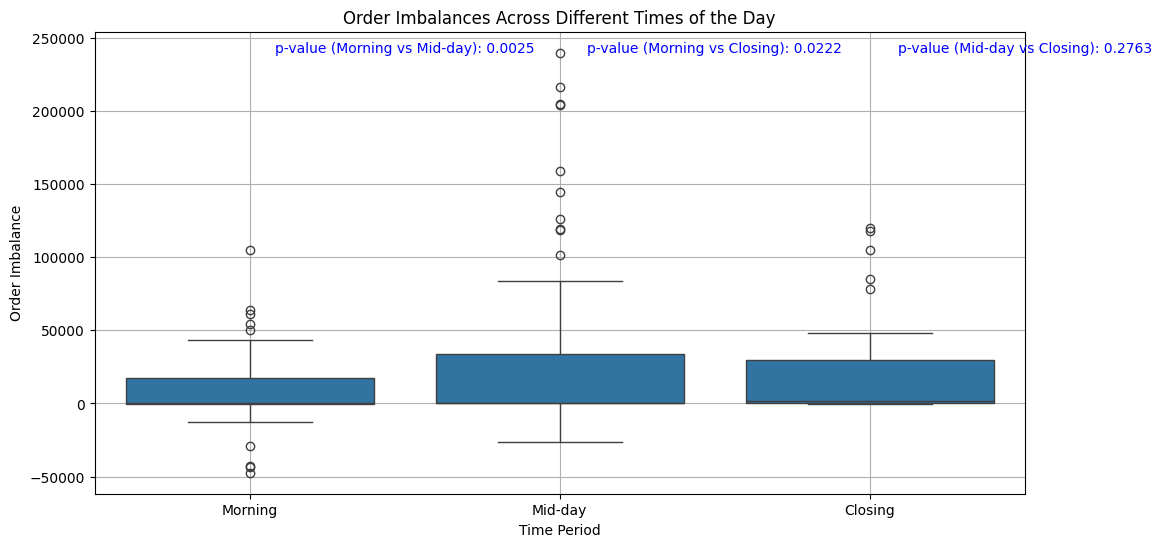

In [ ]:
# Preparing data for visualization
morning_data['Period'] = 'Morning'
mid_day_data['Period'] = 'Mid-day'
closing_data['Period'] = 'Closing'

# Combining all periods into a single DataFrame
visualization_data = pd.concat([morning_data, mid_day_data, closing_data])

# Plotting the data using seaborn boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Period', y='Order Imbalance', data=visualization_data)
plt.title('Order Imbalances Across Different Times of the Day')
plt.xlabel('Time Period')
plt.ylabel('Order Imbalance')
plt.grid(True)

# Annotating p-values on the plot
plt.text(0.5, max(visualization_data['Order Imbalance']), f"p-value (Morning vs Mid-day): {morning_vs_midday.pvalue:.4f}", horizontalalignment='center', color='blue')
plt.text(1.5, max(visualization_data['Order Imbalance']), f"p-value (Morning vs Closing): {morning_vs_closing.pvalue:.4f}", horizontalalignment='center', color='blue')
plt.text(2.5, max(visualization_data['Order Imbalance']), f"p-value (Mid-day vs Closing): {midday_vs_closing.pvalue:.4f}", horizontalalignment='center', color='blue')

plt.show()

In [ ]:
os._exit(00)
